### Celldom Segmentation - Experiment 1

- Segmenting all classes ex CellClump
- Using cell centers as radius=3 circles
- COCO initialization, ResNet50 backbone, 50 iterations on head layers, 0 on rest
- 22 training images, 8 validation
- Subtract occlusions from masks
- allow_growth and per_process_gpu_memory_fraction are a must to avoid random CUDA errors that give different messages depending on TF version
    - 1.8 - gives "work count not > 0" 
    - 1.7 and 1.6 - complain about cuDNN version not being compatible

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

""" Logging initialization for use in notebooks (%run -m flowdec.nb.logging) """
import logging
console = logging.StreamHandler()
console.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s:%(name)s: %(message)s'))
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(console)
logging.basicConfig()

# Root directory of the project
ROOT_DIR = os.path.abspath("../../models/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = "logs/exp1"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
    
import keras.backend.tensorflow_backend as KTF
def get_session(gpu_fraction=0.75):
    """Assume that you have 6GB of GPU memory and want to allocate ~2GB"""
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    config = tf.ConfigProto(gpu_options=gpu_options)
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

KTF.set_session(get_session())
 

c:\users\user\anaconda3\envs\celldom\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os.path as osp
import fnmatch
import os
import xml.etree.ElementTree
import cv2
from collections import namedtuple
from collections import defaultdict
from skimage.draw import polygon_perimeter, polygon, ellipse
from skimage.measure import regionprops

DATA_DIR = 'C:/Users/User/data/celldom/example_data'

Annot = namedtuple('Annot', ['mask', 'border', 'points', 'object_type', 'bound_type', 'properties'])
Img = namedtuple('Img', ['image', 'annotations', 'file'])


def get_centroid_mask(annotation, radius=1, mask_value=np.iinfo(np.uint8).max):
    m = np.zeros_like(annotation.mask)
    centroid = np.array(annotation.properties.centroid).astype(np.int32)
    rr, cc = ellipse(centroid[0], centroid[1], radius, radius, shape=m.shape)
    m[rr, cc] = mask_value
    return m

def parse_object(o, img_shape, mask_value=np.iinfo(np.uint8).max):
    o_type = o.find('name').text
    
    if o.find('polygon'):
        # <polygon>
        #   <x1>122</x1>
        #   <y1>32</y1>
        #   <x2>106</x2>
        #   <y2>48</y2>
        #   ...
        # </polygon>
        bound = 'polygon'
        coords = o.find('polygon').getchildren()
        assert len(coords) % 2 == 0
        pts = []
        for i in range(0, len(coords), 2):
            xc, yc = coords[i], coords[i+1]
            xi, xv = int(xc.tag.replace('x', '')), int(xc.text)
            yi, yv = int(yc.tag.replace('y', '')), int(yc.text)
            assert xi == yi == i // 2 + 1
            pts.append([xv, yv])
    elif o.find('bndbox'):
        # <bndbox>
        #   <xmin>245</xmin>
        #   <ymin>54</ymin>
        #   <xmax>300</xmax>
        #   <ymax>98</ymax>
        # </bndbox>
        bound = 'box'
        bb = o.find('bndbox')
        xmin, ymin, xmax, ymax = [int(bb.find(p).text) for p in ['xmin', 'ymin', 'xmax', 'ymax']]
        pts = [
            [xmin, ymin],
            [xmin, ymax],
            [xmax, ymax],
            [xmax, ymin]
        ]
    else:
        raise ValueError('Cound not determine mask shape')

    pts = np.array(pts)
    r, c = pts[:,1], pts[:,0]
    
    mask = np.zeros(img_shape, dtype=np.uint8)
    rr, cc = polygon(r, c, shape=img_shape)
    mask[rr, cc] = mask_value
    
    border = np.zeros(img_shape, dtype=np.uint8)
    rr, cc = polygon_perimeter(r, c, shape=img_shape)
    border[rr, cc] = mask_value
    
    props = regionprops(mask)
    assert len(props) == 1
    
    
    
    return Annot(mask, border, pts, o_type, bound, props[0])

def load_annotations(annot_path):
    e = xml.etree.ElementTree.parse(annot_path).getroot()
    w = int(e.find('size').find('width').text)
    h = int(e.find('size').find('height').text)
    img_shape = (h, w)
    annot = []
    for o in e.findall('object'):
        try:
            obj = parse_object(o, img_shape)
            annot.append(obj)
        except:
            print('Failed to process object {}'.format(xml.etree.ElementTree.tostring(o, encoding='utf8', method='xml')))
            raise
    return img_shape, annot

def load_images(img_path, channel=0, annot_path=None, pattern='BF_*.jpg'):
    if annot_path is None:
        annot_path = osp.join(img_path, 'annotations')
        
    img_files = fnmatch.filter(os.listdir(img_path), pattern)
    imgs = []
    for f in img_files:
        img_file = osp.join(img_path, f)
        img = cv2.imread(img_file)[..., channel]
        annot = None
        annot_file = osp.join(annot_path, f.split('.')[0] + '.xml')
        if osp.exists(annot_file):
            annot_shape, annot = load_annotations(annot_file)
            assert img.shape == annot_shape, \
                'Image has shape {} but annotations are for shape {}'.format(img.shape, annot_shape)
        imgs.append(Img(img, annot, img_file))
    return imgs
        
            

In [3]:
#img = cv2.imread(osp.join(DATA_DIR, 'BF_ST_015_APT_010Day3.jpg'))

In [4]:
#objs = load_objects(osp.join(DATA_DIR, 'annotations', 'BF_ST_001_APT_004Day1.xml'))
imgs = load_images(DATA_DIR)

In [5]:
# pd.DataFrame([
#     pd.Series([a.object_type for a in i.annotations]).value_counts()
#     for i in imgs if i.annotations
# ])

In [6]:
pd.Series([a.object_type for i in imgs if i.annotations for a in i.annotations ]).value_counts()

Cell         961
CellClump     46
Chamber       33
AptNum        32
StNum         32
Marker        31
dtype: int64

In [7]:
imgs[0].image.shape

(300, 324)

In [8]:
from functools import reduce
img = [i for i in imgs if i.annotations is not None][3]
print(img.file)

C:/Users/User/data/celldom/example_data\BF_ST_001_APT_000Day3.jpg


In [9]:
img.annotations[0]

Annot(mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), border=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), points=array([[254,  59],
       [254, 106],
       [310, 106],
       [310,  59]]), object_type='AptNum', bound_type='box', properties=<skimage.measure._regionprops._RegionProperties object at 0x00000207886740B8>)

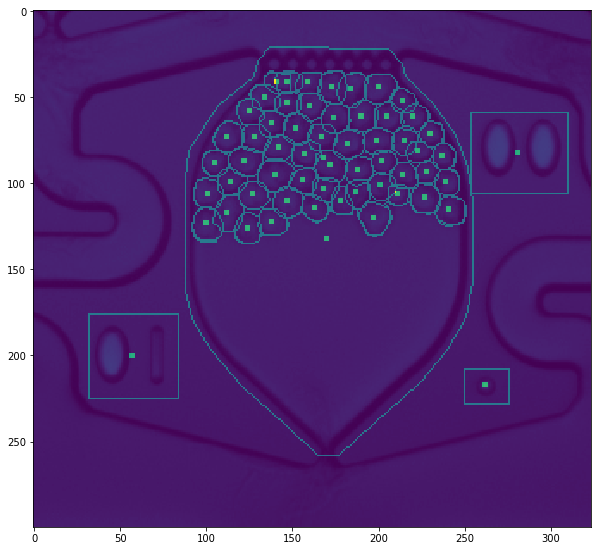

In [10]:
mask_img = reduce(lambda i1, i2: np.maximum(i1, i2), [a.border for a in img.annotations], np.zeros_like(img.image))
cent_img = reduce(lambda i1, i2: np.maximum(i1, i2), [get_centroid_mask(a, radius=2) for a in img.annotations], np.zeros_like(img.image))

a = [.3, .5, .2] 
plt.imshow(a[0] * mask_img + a[1] * cent_img + a[2]*img.image)
plt.gcf().set_size_inches(10, 12)

## Configurations

In [11]:
class CellsConfig(Config):
    """Configuration for training on cell plate datasets"""
    # Give the configuration a recognizable name
    NAME = "cells"

    # BACKBONE = "resnet101"
    BACKBONE = "resnet50"
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    # IMAGES_PER_GPU = 8
    IMAGES_PER_GPU = 2
    
    # BATCH_SIZE = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # background + 5 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CellsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MIN

## Dataset

In [13]:
from skimage.color import gray2rgb

class CellsDataset(utils.Dataset):
    """Generates the cells dataset."""

    
    def load_cells(self, image_dir, indexes):
        imgs = load_images(image_dir)
        
        classes = ['StNum', 'AptNum', 'Marker', 'Chamber', 'Cell']
        for i, c in enumerate(classes):
            self.add_class('cells', i+1, c)
        
        cases = []
        for i, img in enumerate(imgs):
            if img.annotations is None:
                continue
            uniq_type = np.unique([a.object_type for a in img.annotations])
            if len(np.setdiff1d(classes, uniq_type)) > 0:
                continue
            cases.append((i, img))
        
        for i in indexes:
            self.add_image('cells', image_id=cases[i][0], path=None, data=cases[i][1])

    def load_image(self, image_id):
        info = self.image_info[image_id]
        return gray2rgb(info['data'].image)#[:,4:]

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "cells":
            return info["data"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        data = info['data']
        
        # Remove any unnecessary segmentation masks
        annotations = [a for a in data.annotations if a.object_type in self.class_names]
        count = len(annotations)
        shape = data.image.shape
        mask = np.zeros([shape[0], shape[1], count], dtype=np.uint8)
        
        # Sort annotations by index of object/mask type
        class_ids = np.array([self.class_names.index(a.object_type) for a in annotations], dtype=np.int32)
        o = np.argsort(class_ids)
        class_ids = class_ids[o]
        sort_annots = [annotations[i] for i in list(o)]
            
        # Traverse annotations by type in specified order noting that the higher
        # the id of the class, the closer to the "top" of the image the mask
        # will be once occlusions are applied
        for i, a in enumerate(sort_annots):
            # Use cell centroid rather than boundary
            if a.object_type == 'Cell':
                m = get_centroid_mask(a, radius=2)
            else:
                m = a.mask
            mask[:, :, i] = m
            #mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(), shape, dims, 1)
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))

        #return mask.astype(np.bool)[:,4:,:], class_ids
        return mask.astype(np.bool), class_ids


In [14]:
# Training dataset
dataset_train = CellsDataset()
dataset_train.load_cells(DATA_DIR, list(range(22)) * 10)
dataset_train.prepare()

# # Validation dataset
dataset_val = CellsDataset()
dataset_val.load_cells(DATA_DIR, list(range(22, 30)) * 10)
dataset_val.prepare()

In [15]:
len(dataset_train.image_ids)

220

In [16]:
dataset_train.class_info

[{'source': '', 'id': 0, 'name': 'BG'},
 {'source': 'cells', 'id': 1, 'name': 'StNum'},
 {'source': 'cells', 'id': 2, 'name': 'AptNum'},
 {'source': 'cells', 'id': 3, 'name': 'Marker'},
 {'source': 'cells', 'id': 4, 'name': 'Chamber'},
 {'source': 'cells', 'id': 5, 'name': 'Cell'}]

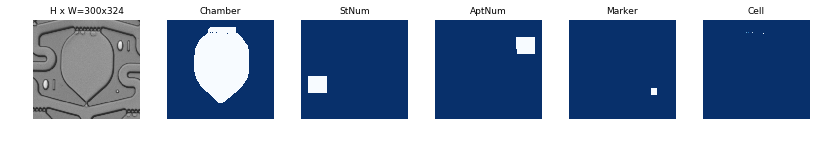

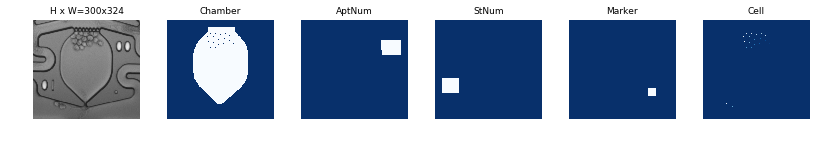

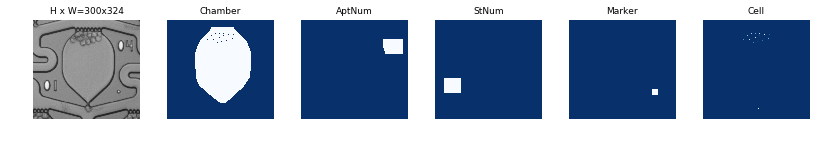

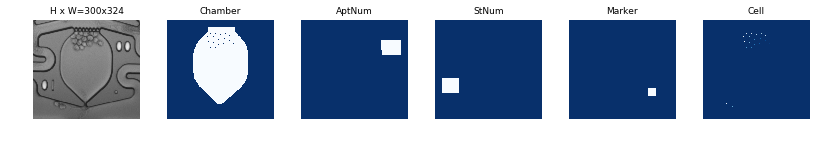

<Figure size 1152x1152 with 0 Axes>

In [17]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=5)
plt.gcf().set_size_inches(16, 16)

## Ceate Model

In [36]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [37]:
# Which weights to start with?
#init_with = "coco"  # imagenet, coco, or last
#init_with = "imagenet"  # imagenet, coco, or last
init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [38]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: logs\cells20180519T1902\mask_rcnn_cells_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistri

c:\users\user\anaconda3\envs\celldom\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
100/100 [==============================] - 137s 1s/step - loss: 0.4982 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.2317 - val_loss: 1.2795 - val_rpn_class_loss: 0.0899 - val_rpn_bbox_loss: 0.3657 - val_mrcnn_class_loss: 0.2575 - val_mrcnn_bbox_loss: 0.2346 - val_mrcnn_mask_loss: 0.3318
Epoch 2/30
100/100 [==============================] - 135s 1s/step - loss: 0.5252 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.2416 - val_loss: 1.1780 - val_rpn_class_loss: 0.0816 - val_rpn_bbox_loss: 0.3890 - val_mrcnn_class_loss: 0.2020 - val_mrcnn_bbox_loss: 0.2059 - val_mrcnn_mask_loss: 0.2996
Epoch 3/30
100/100 [==============================] - 131s 1s/step - loss: 0.5021 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.2343 - val_loss: 1.2454 - val_rpn_class_l

In [69]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: logs\cells20180519T1702\mask_rcnn_cells_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm

c:\users\user\anaconda3\envs\celldom\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
100/100 [==============================] - 178s 2s/step - loss: 0.3560 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0068 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.2304 - val_loss: 1.4480 - val_rpn_class_loss: 0.1879 - val_rpn_bbox_loss: 0.5213 - val_mrcnn_class_loss: 0.2075 - val_mrcnn_bbox_loss: 0.2241 - val_mrcnn_mask_loss: 0.3073
Epoch 2/20
100/100 [==============================] - 170s 2s/step - loss: 0.3758 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.0077 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.2342 - val_loss: 1.5909 - val_rpn_class_loss: 0.1678 - val_rpn_bbox_loss: 0.5260 - val_mrcnn_class_loss: 0.2282 - val_mrcnn_bbox_loss: 0.2928 - val_mrcnn_mask_loss: 0.3762
Epoch 3/20
100/100 [==============================] - 162s 2s/step - loss: 0.3670 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.2329 - val_loss: 1.3056 - val_rpn_class_l

KeyboardInterrupt: 

In [12]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [39]:
class InferenceConfig(CellsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs\cells20180519T1902\mask_rcnn_cells_0030.h5


original_image           shape: (384, 384, 3)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (18,)                 min:    1.00000  max:  384.00000  float64
gt_class_id              shape: (66,)                 min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (66, 4)               min:   48.00000  max:  345.00000  int32
gt_mask                  shape: (384, 384, 66)        min:    0.00000  max:    1.00000  bool


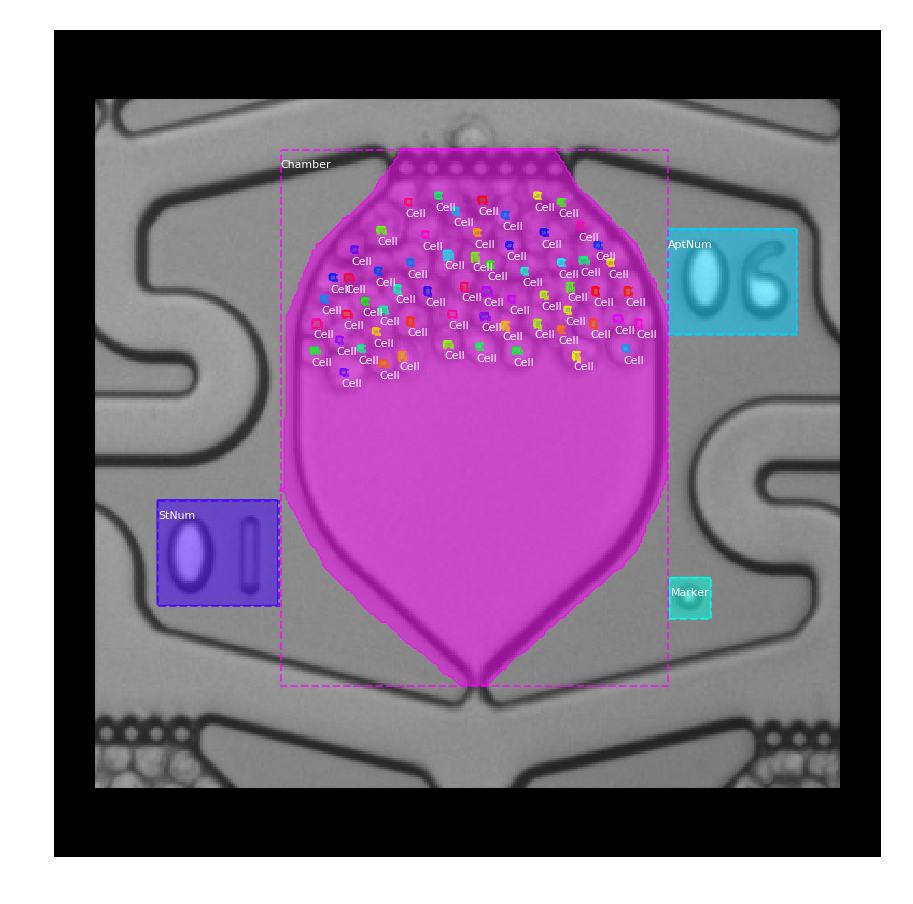

In [71]:
# Test on a random image
dataset_pred = dataset_val
#dataset_pred = dataset_train
image_id = random.choice(dataset_pred.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_pred, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16, 16))

In [72]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  384.00000  int32
anchors                  shape: (1, 36828, 4)         min:   -0.23632  max:    1.06922  float32


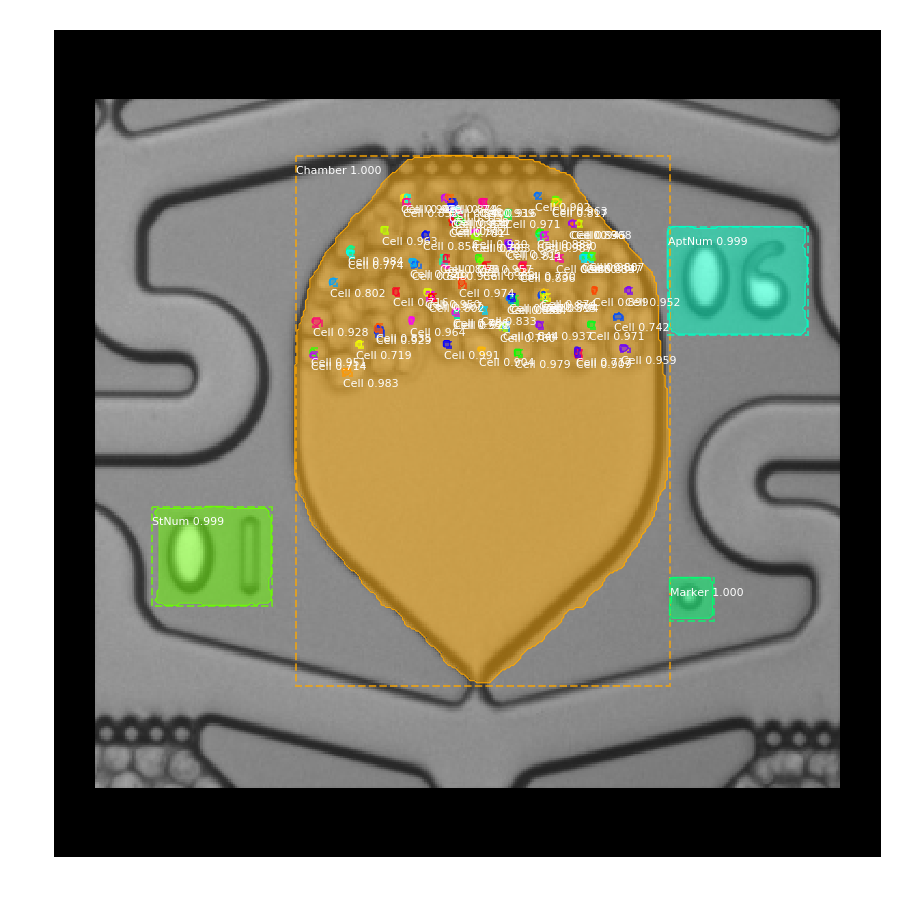

In [73]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [74]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.2564559355686101


In [75]:
APs

[0.07222693727729591,
 0.3452381044626236,
 0.07222693727729591,
 0.3156220335838122,
 0.14349541524682044,
 0.14349541524682044,
 0.3156220335838122,
 0.21313705183987064,
 0.800000011920929,
 0.14349541524682044]